In [17]:
from qiskit import QuantumCircuit, Aer, transpile
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import argparse
import json
from sys import platform

folder = os.getcwd()
while not folder.endswith("AutomatedPERTools"):
    folder = os.path.dirname(folder)
sys.path.append(os.path.join(folder, "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

In [18]:
case_number = 3
which_file = 0
recalculate_ideals = False
take_ideals_from_other_file = True and not recalculate_ideals
file_to_take_res_ans_noise_from = "False_False_64_1000_1000_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json"

if platform == "linux" or platform == "linux2":
    pre="/home/fabrice/Dokumente/"
    # linux
elif platform == "darwin":
    raise Exception("IOS Not supported")
    # OS X
elif platform == "win32":
    pre="E:/OneDrive/Dokumente/Uni_kram/"

match case_number:
    case 0:
        jsonfiles = [
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_False_16_100_100_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/True_False_16_100_100_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_True_16_100_100_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',]
    case 1:
        jsonfiles = [
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_False_16_100_100_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/True_False_16_100_100_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_True_16_100_100_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',]
    case 2:
        jsonfiles = [
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_False_64_1000_1000_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/True_False_64_1000_1000_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_True_64_1000_1000_1000_FakeCasablancaV2_[0,1,2,3]_and_transpile__arrays.json',]
    case 3:
        jsonfiles = [
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_False_64_1000_1000_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/True_False_64_1000_1000_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',
            'Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun1/False_True_64_1000_1000_1000_FakeMelbourneV2_[0,1,2,3]_and_transpile__arrays.json',]
jsonfiles = ["Masterarbeit/AutomatedPERTools/False_False_16_100_100_1024_FakeVigoV2_False_[0,1,2,3]_and_transpile__arrays.json"]
for i, file in enumerate(jsonfiles):
    jsonfiles[i] = pre+file
namebase = os.path.basename(jsonfiles[which_file][:len(jsonfiles[which_file])-12])
if take_ideals_from_other_file:
    recalculate_ideals = False 

In [19]:
split_namebase = namebase.split("_")
#parser.add_argument('--plusone', '-p', help='Takes Neighboring qubits into account', default=False, action='store_true')
tomography_connections = (split_namebase[0] == "True")
#parser.add_argument('--sum', '-s', help='Same as -p and turns sumation on over neighboring qubits', default=False, action='store_true')
sum_over_lambda = (split_namebase[1] == "True")
if sum_over_lambda:
    tomography_connections = True
#parser.add_argument('--pntsamples', type=int, help='How many samples in PNT? Default: 16', default=16)
pntsamples = int(split_namebase[2])
#parser.add_argument('--pntsinglesamples', type=int, help='How many single samples in PNT? Default: 100', default=100)
pntsinglesamples = int(split_namebase[3])
#parser.add_argument('--persamples', type=int, help='How many samples in PER? Default: 100', default=100)
persamples = int(split_namebase[4])
#parser.add_argument('--shots', type=int, help='How many shots? Default: 1000', default=1000)
shots = int(split_namebase[5])
#parser.add_argument('--backend', type=str, help='Which backend to use? Default: FakeVigoV2', default="FakeVigoV2")
import qiskit.providers.fake_provider as fake_provider
backend = fake_provider.FakeVigoV2()
if split_namebase[6] != "FakeVigoV2":
    method = getattr(fake_provider, split_namebase[6])
    backend = method()

#parser.add_argument('--cross', '-c', help='Simulates Cross Talk Noise', default=False, action='store_true')
do_cross_talk_noise = (split_namebase[7] == "True")

#parser.add_argument('--setqubits', type=int, nargs='+', help='Which qubits to use?: Default: 0123 and transpile')
import ast
qubits= ast.literal_eval(split_namebase[8])
num_qubits = len(qubits)
#if split_namebase[7] == '[0,1,2,3]' and split_namebase[8] == 'and' and split_namebase[9] == 'transpile':

In [20]:
data = {}
with open(jsonfiles[which_file], 'r') as file:
    data = json.load(file)
results_errors = [d1 for d1 in data["results_errors"]] # This needs to change later
results_at_noise = [[d1,d2,d3,d4] for d1, d2, d3, d4 in data["results_at_noise"]]
results_at_noise_errors = [[d1,d2,d3,d4] for d1, d2, d3, d4 in data["results_at_noise_errors"]]
results = [d for d in data["results"]]
if take_ideals_from_other_file:
    with open(file_to_take_res_ans_noise_from, 'r') as file:
        res_noise_data = json.load(file)
    noisyresult = [d for d in res_noise_data["noisyresult"]]
    res = res_noise_data["res"]
else:
    noisyresult = [d for d in data["noisyresult"]]
    res = data["res"]

In [21]:
def trotterLayer(h,J,dt,n):
    n=2
    trotterLayer = QuantumCircuit(num_qubits)
    trotterLayer.rx(dt*4*h, qubits)
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+1] for i in range(n)])
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+2] for i in range(n-1)])
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(num_qubits)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,15)]
used_qubits = set()
for circuit in circuits: 
    for ft3 in circuit: #look at the commands
        for bit in ft3.qubits: #record which qubits they use
            used_qubits.add(bit.index) #and save those
qubits = used_qubits
#print("Qubits set to ", qubits)

C:\Users\fabri\AppData\Local\Temp\ipykernel_24920\3842205834.py:33: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  used_qubits.add(bit.index) #and save those


In [22]:
noise_strengths = [0,0.5,1,2]
expectations = []
for q in qubits:
    expect = "I"*(backend.num_qubits) #15
    expect = expect[:q] + 'Z' + expect[q+1:]
    expectations.append("".join(reversed(expect)))

In [23]:
if recalculate_ideals:
    noisyresult = []
    for circ in circuits:
        print(circuits.index(circ))
        qc = circ.copy()
        qc.measure_all()
        count= backend.run(qc, shots=shots*persamples).result().get_counts()
        count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
        tot = 0
        for key in count.keys():
            num = sum([(-1)**bit for i, bit in enumerate(key) if len(key)-1-i in qubits])
            tot += num*count[key]
        noisyresult.append(tot/(shots*persamples*n*2))
    data["noisyresult"] = noisyresult

In [24]:
if recalculate_ideals:
    res = []
    for circ in circuits:
        print(circuits.index(circ))
        qc = circ.copy()
        qc.measure_all()
        count= Aer.get_backend('qasm_simulator').run(qc, shots=shots*persamples).result().get_counts()
        count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
        tot = 0
        for key in count.keys():
            num = sum([(-1)**bit for i, bit in enumerate(key) if len(key)-1-i in qubits])
            tot += num*count[key]
        res.append(tot/(shots*persamples*n*2))
    data["res"] = res
    with open(jsonfiles[which_file], 'w') as file:
        json.dump(data, file)

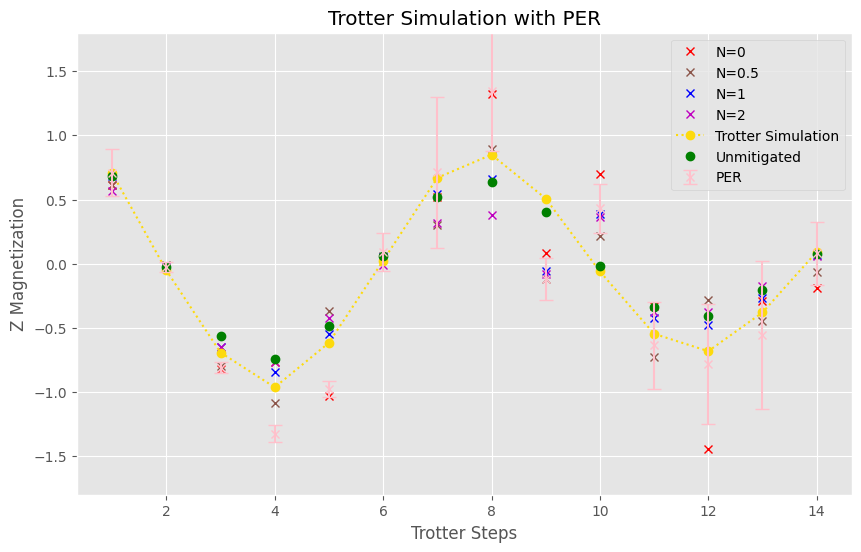

In [25]:
plt.figure(figsize=(10,6))
colors = ['r', 'tab:brown', 'b', 'm']
for i, noise in enumerate(noise_strengths):
    plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise), color=colors[i])
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation", color='#FDDA0D')
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated", color='g')
#plt.plot(range(1,15), results, 'o', label="PER", color='#FFC0CB')
plt.errorbar(range(1,15), results, yerr=results_errors, fmt='x', capsize=5, label="PER", color='#FFC0CB')

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
plt.savefig(namebase+"_Trotter_Sim_PER.png")

Text(0, 0.5, 'Z Magnetization')

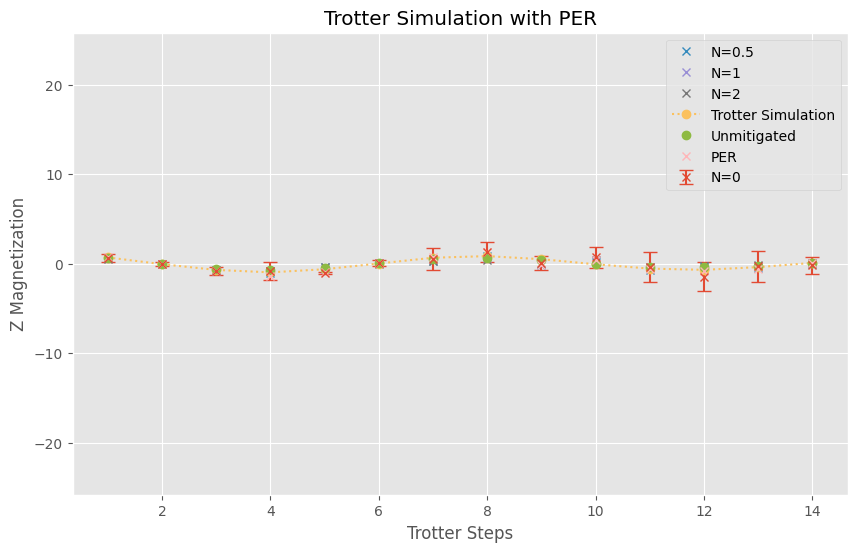

In [26]:
plt.figure(figsize=(10,6))
for i, noise in enumerate(noise_strengths):
    if noise == 0:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], capsize=5, label='N='+str(noise))
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-25.8,25.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
#plt.savefig(namebase+"_Trotter_Sim_n_0.png")

Text(0, 0.5, 'Z Magnetization')

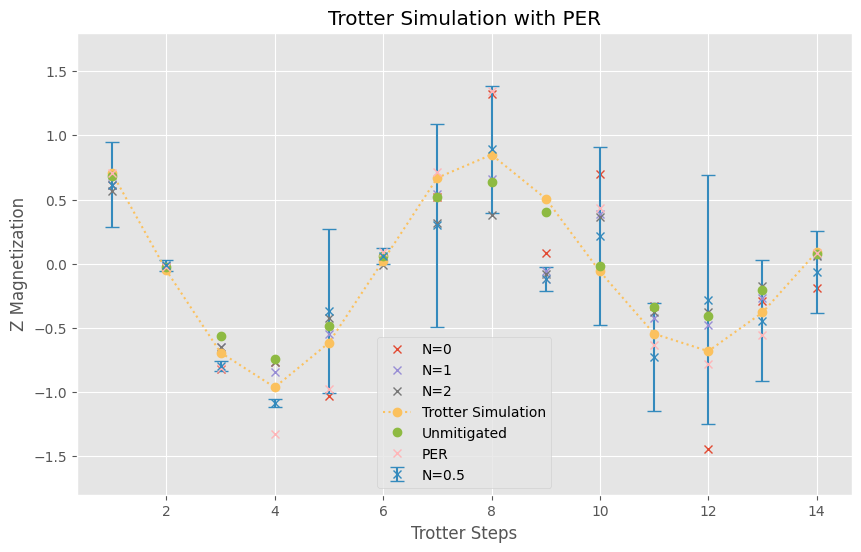

In [27]:
plt.figure(figsize=(10,6))
for i, noise in enumerate(noise_strengths):
    if noise == 0.5:
        plt.errorbar(range(1,15), [res[i] for res in results_at_noise], fmt='x', yerr=[res[i] for res in results_at_noise_errors], label='N='+str(noise), capsize=5)
    else:
        plt.plot(range(1,15), [res[i] for res in results_at_noise], 'x', label='N='+str(noise))
        
    
plt.plot(range(1,15), res, 'o:', label="Trotter Simulation")
plt.plot(range(1,15), noisyresult, 'o', label="Unmitigated")
plt.plot(range(1,15), results, 'x', label="PER")

plt.ylim([-1.8,1.8])
plt.legend()
plt.title("Trotter Simulation with PER")
plt.xlabel("Trotter Steps")
plt.ylabel("Z Magnetization")
#plt.savefig(namebase+"_Trotter_Sim_n_05.png")

In [28]:
#for i in range (len(expectations)):
#    ax = circuit_results[0].get_result(expectations[i]).plot()
#    plt.title("Expectation vs Noise Strength " + expectations[i])
#    plt.xlabel("Noise Strength")
#    plt.ylabel("Expectation")
#    plt.savefig(namebase+"_Expectation_vs_Noise_Strength_" + expectations[i] + ".png")

In [29]:
namebases = []
data = {}
for jfilename in jsonfiles:
    namebase = os.path.basename(jfilename)
    namebase = namebase[:len(namebase)-12]
    namebases.append(namebase)
    with open(jfilename, 'r') as file:
        data[namebase] = json.load(file) # names are: results, results_errors, results_at_noise, results_at_noise_errors, noisyresult, res
    data[namebase]["results_total_errors"] = [abs(a[0]) + abs(a[1]) for a in data[namebase]["results_errors"]]
    #data[namebase]["results_total_errors"] = data[namebase]["results"]

import matplotlib.pyplot as plt
import numpy as np

# Sample data
ff1 = data[namebases[0]]["results_total_errors"]
tf2 = data[namebases[1]]["results_total_errors"]
ft3 = data[namebases[2]]["results_total_errors"]

# Number of bars
n = len(ff1)

# Positions of groups on the x-axis
ind = np.arange(n)

# Width of bars
width = 0.2

# Create a bar plot
fig, ax = plt.subplots(figsize=(15,6))
# Plotting the bars
bar1 = ax.bar(ind - width, ff1, width, label="Without extra qubits")#namebases[0])
bar2 = ax.bar(ind, tf2, width, label="With extra qubits")
bar3 = ax.bar(ind + width, ft3, width, label="With extra qubits an summation")

# Adding labels
ax.set_xlabel('Trotter Steps')
ax.set_ylabel('Expectation')
ax.set_title('Bar plot of the error values of the PER fits on FakeMelbourneV2')
ax.set_xticks(ind)
ax.set_xticklabels([f'{i+1}' for i in range(n)])

#plt.ylim([0,30])

# Add a legend
ax.legend()
namebase = ""
for i, name in enumerate(split_namebase):
    if i >= 3:
        namebase +=name+"_"
    
plt.savefig(namebase+"Error_Comparison.png")

rel_value1 = [b/a for a,b in zip(ff1, tf2)]
average1 = sum(rel_value1)/len(rel_value1)
print(average1)
rel_value2 = [b/a for a,b in zip(ff1, ft3)]
average2 = sum(rel_value2)/len(rel_value2)
print(average2)
#for i, t in enumerate(rel_value1):
#    print(str(i+1)+": "+ str(t))

TypeError: 'float' object is not subscriptable

: 